In [2]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import os
import seaborn as sns
from math import *
import random

In [3]:
class float3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
    def __add__(self, v):
        return float3(self.x + v.x, self.y + v.y, self.z + v.z)
    
    def __iadd__(self, v):
        return float3(self.x + v.x, self.y + v.y, self.z + v.z)
    
    def __neg__(self):
        return float3(-self.x, -self.y, -self.z)
    
    def __sub__(self, v):
        return float3(self.x - v.x, self.y - v.y, self.z - v.z)
    
    def __isub__(self, v):
        return float3(self.x - v.x, self.y - v.y, self.z - v.z)
    
    def __imul__(self, v):
        return float3(self.x * v.x, self.y * v.y, self.z * v.z)    
    
    def __mul__(self, v):
        return float3(self.x * v.x, self.y * v.y, self.z * v.z)
    
    def mul(self, t):
        return float3(self.x * t, self.y * t, self.z * t)
    
    def __truediv__(self, v):
        if v.length() == 0 or v.x == 0 or v.y == 0 or v.z == 0:
            print('Could not divide float3 value by v because zero division will occur.')
            return self
        return float3(self.x / v.x, self.y / v.y, self.z / v.z)
    
    def div(self, t):
        if t == 0:
            print('Could not divide float3 value by v because zero division will occur.')
            return self
        return self.mul(1.0 / t)
    
    def __str__(self):
        return '{} {} {}'.format(self.x, self.y, self.z)
    
    def length(self):
        return sqrt(dot(self, self))

def dot(v1, v2):
    return v1.x*v2.x + v1.y*v2.y + v1.z*v2.z

def cross(v1, v2):
    return float3(v1.y*v2.z - v1.z*v2.y, v1.z*v2.x - v1.x*v2.z, v1.x*v2.y - v1.y*v2.x)

def normalize(v):
    return v.div(v.length())
    
# test
a = float3(1.0, 2.0, 3.0)
b = float3(4.0, 5.0, 6.0)
print('add:', a + b)
print('sub:', a - b)
print('mul:', a * b)
print('mul:', a )
print('truediv:', a.div(2.0))
print('dot:', dot(a, b))
print('cross:', cross(a, b))
print('normalize:', normalize(a))
print('normalize.length():', normalize(a).length())


add: 5.0 7.0 9.0
sub: -3.0 -3.0 -3.0
mul: 4.0 10.0 18.0
mul: 1.0 2.0 3.0
truediv: 0.5 1.0 1.5
dot: 32.0
cross: -3.0 6.0 -3.0
normalize: 0.2672612419124244 0.5345224838248488 0.8017837257372732
normalize.length(): 1.0


In [4]:
class Onb:
    # n ... float3
    def __init__(self, n):
        self.normal = n
        self.binormal = float3(0.0, 0.0, 0.0)
        self.tangent = float3(0.0, 0.0, 0.0)
        
        if abs(self.normal.x) > abs(self.normal.z):
            self.binormal.x = -self.normal.y
            self.binormal.y = self.normal.x
            self.binormal.z = 0.0
        else:
            self.binormal.x = 0.0
            self.binormal.y = -self.normal.z
            self.binormal.z = self.normal.y
        
        self.binormal = normalize(self.binormal)
        self.tangent = cross(self.binormal, self.normal)
        
    def inverse_transform(self, p):
        return self.tangent.mul(p.x) + self.binormal.mul(p.y) + self.normal.mul(p.z)
    

In [5]:
def prepare_3dplot():
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')
    axes.set(xlabel='x', ylabel='y', zlabel='z')
    return fig, axes

def plot_float3(axes, v, scale):
    axes.scatter(v.x, v.y, v.z)

# Test for several sampling strategies

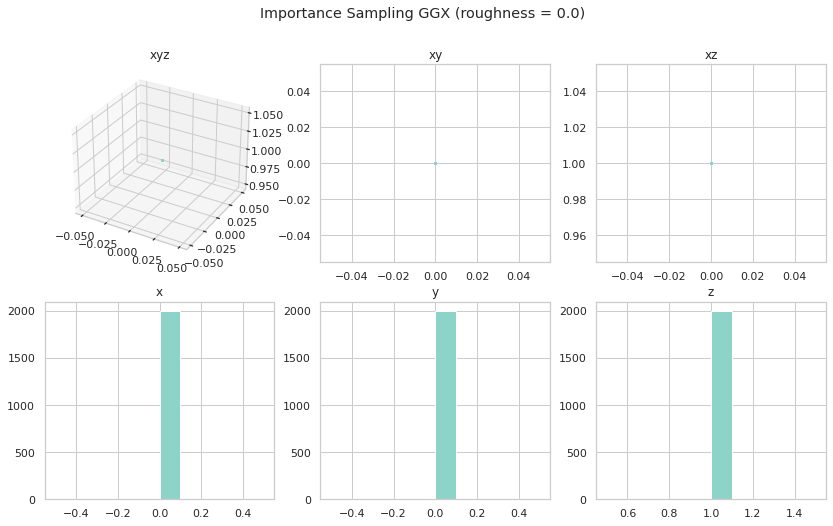

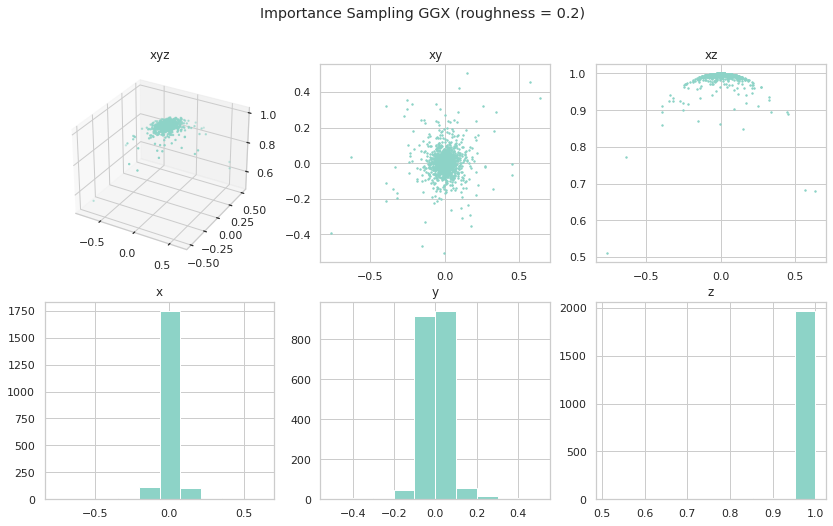

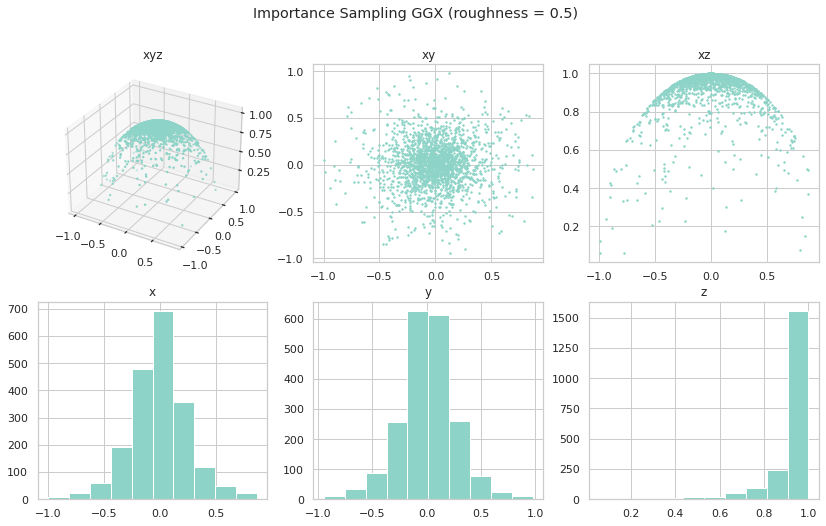

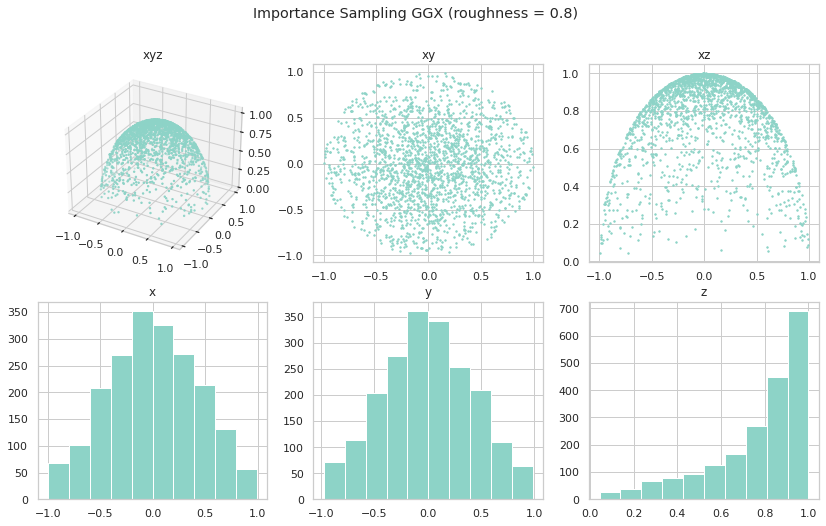

In [195]:
# random
def random_sample_hemisphere(n, **kwargs):
    w_out = float3(random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1))
    w_out = normalize(w_out)
    if dot(w_out, n) < 0:
        return -w_out
    return w_out

# cosine
def cosine_sample_hemisphere(n, **kwargs):
    z1 = random.random()
    z2 = random.random()
    r = sqrt(z1)
    phi = 2.0 * pi * z2
    x = r * cos(phi)
    y = r * sin(phi)
    z = sqrt(max(0.0, 1.0 - x*x - y*y))
    return float3(x, y, z)

# ref: https://learnopengl.com/PBR/IBL/Specular-IBL
def importance_sample_ggx(n, **kwargs):
    roughness = kwargs['roughness']
    z1 = random.random()
    z2 = random.random()
    a = roughness*roughness
    phi = 2.0 * pi * z1
    cos_theta = sqrt((1.0 - z2) / (1.0 + (a*a - 1.0) * z2))
    sin_theta = sqrt(1.0 - cos_theta*cos_theta)
    
    x = cos(phi) * sin_theta
    y = sin(phi) * sin_theta
    z = cos_theta
    
    up = float3(0.0, 0.0, 1.0) if n.z < 0.999 else float3(1.0, 0.0, 0.0)
    tangent = normalize(cross(up, n))
    bitangent = cross(n, tangent)
    
    sample_vec = tangent.mul(x) + bitangent.mul(y) + n.mul(z)
    return normalize(sample_vec)

def plot_sampling_func_3d(sample_func, normal, num_samples=500):
    fig, axes = prepare_3dplot()
    for i in range(num_samples):
        w_out = sample_func(normal)
        plot_float3(axes, w_out, 5.0)
    plt.show()
    
def plot_sampling_func(sample_func, normal, func_name, roughness=0.5, num_samples=500, wi=float3(0.0, 0.0, 1.0)):
    xs = []
    ys = []
    zs = []
    for i  in range(num_samples):
        w_out = sample_func(normal, roughness=roughness, wi=wi)
        xs.append(w_out.x)
        ys.append(w_out.y)
        zs.append(w_out.z)
        
    sns.set()
    sns.set_style('whitegrid')
    sns.set_palette('Set3')
        
#     plt.clf()
    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(func_name)
    ax = fig.add_subplot(231, projection='3d')
    ax.scatter(xs, ys, zs, s=2)
    ax.set_title('xyz')
    ax = fig.add_subplot(232)
    ax.scatter(xs, ys, s=2)
    ax.set_title('xy')
    ax = fig.add_subplot(233)
    ax.scatter(xs, zs, s=2)
    ax.set_title('xz')
#     plt.show()

    ax = fig.add_subplot(234)
    ax.hist(xs)
    ax.set_title('x')
    ax = fig.add_subplot(235)
    ax.hist(ys)
    ax.set_title('y')
    ax = fig.add_subplot(236)
    ax.hist(zs)
    ax.set_title('z')
#     plt.show()

    plt.savefig(func_name + '.png')

if __name__ == '__main__':
    normal = float3(0, 0, 1)
    roughness = 0.0
    plot_sampling_func(importance_sample_ggx, normal, 'Importance Sampling GGX (roughness = {})'.format(roughness), roughness, 2000)
    roughness = 0.2
    plot_sampling_func(importance_sample_ggx, normal, 'Importance Sampling GGX (roughness = {})'.format(roughness), roughness, 2000)
    roughness = 0.5
    plot_sampling_func(importance_sample_ggx, normal, 'Importance Sampling GGX (roughness = {})'.format(roughness), roughness, 2000)
    roughness = 0.8
    plot_sampling_func(importance_sample_ggx, normal, 'Importance Sampling GGX (roughness = {})'.format(roughness), roughness, 2000)

# BRDF and PDF evaluation

In [238]:
def reflect(wi, n):
    return wi - n.mul(2.0 * dot(wi, n))

def luminance(c):
    return 0.3 * c.x + 0.6 * c.y + 0.1 * c.z

def lerp3(v1, v2, c):
    return v1 + (v2 - v1).mul(c)

def lerp(a,b,c):
    return a + (b-a)*c

def clamp(f, a, b):
    return max(a, min(f, b))

def geometry_schlick_ggx(NdotV, roughness):
    r = (roughness + 1.0)
    k = (r*r) / 8.0
    return NdotV / (NdotV * (1-k) + k)

def geometry_smith(n, v, l, roughness):
    NdotV = max(dot(n, v), 0.0)
    NdotL = max(dot(n, l), 0.0)
    ggxV = geometry_schlick_ggx(NdotV, roughness)
    ggxL = geometry_schlick_ggx(NdotL, roughness)    
    return ggxV * ggxL

def GTR1(NdotH, a):
    if a >= 1.0:
        return 1.0 / pi;
    a2 = a*a
    t = 1.0 + (a2 - 1.0) * NdotH * NdotH
    return (a2 - 1.0) / (pi * log(a2) * t)

def GTR2(NdotH, a):
    a2 = a*a
    t = 1.0 + (a2-1.0)*NdotH*NdotH
    return a2 / (pi * t * t)

def fr_schlick(cos_i, f0):
    return f0 + (1.0 - f0) * pow(1.0 - cos_i, 5)

def ft_schlick(cos_i, f90):
    return 1.0 + (f90 - 1.0) * pow(1.0 - cos_i, 5)

def fr_schlick3(cos_i, f0):
    return f0 + (float3(1.0, 1.0, 1.0) - f0).mul(pow(1.0 - cos_i, 5))

def ft_schlick3(cos_i, f90):
    return 1.0 + (f90 - float3(1.0, 1.0, 1.0)).mul(pow(1.0 - cos_i, 5))

base = float3(1.0, 1.0, 1.0)
subsurface = 0.8
metallic = 1.0
specular = 0.0
specular_tint = 0.0
roughness = 0.1
anisotropic = 0.0
sheen = 0.0
sheen_tint = 0.5
clearcoat = 0.0
clearcoat_gloss = 0.0

def disney_sample(n, **kwargs):
    wi = kwargs['wi']
    z1 = random.random()
    z2 = random.random()
    diffuse_ratio = 0.5 * (1.0 - metallic)
    onb = Onb(n)
    
    if random.random() < diffuse_ratio:
        w_in = cosine_sample_hemisphere(n)
        onb.inverse_transform(w_in)
        return normalize(w_in)
    else:
        h = importance_sample_ggx(n, roughness=roughness)
        onb.inverse_transform(h)
#         wo = reflect(wi, h)
#         return reflect(wi, h).mul(0.0 if dot(wo, n) < 0 else 1.0)
        return reflect(wi, h)
    
def disney_brdf(v, l, n):
    NdotV = dot(n, v)
    NdotL = dot(n, l)
    
    if NdotV <= 0.0 or NdotL <= 0.0:
        return float3(0.0, 0.0, 0.0)
    
    h = normalize(v + l)
    NdotH = dot(n, h)
    LdotH = dot(l, h)
        
    # Diffuse
    Fd90 = 0.5 + 2.0 * roughness * LdotH * LdotH
    FVd90 = ft_schlick(NdotV, Fd90)
    FLd90 = ft_schlick(NdotL, Fd90)
    f_diffuse = base.div(pi).mul(FVd90 * FLd90)
    
    # Subsurface
    Fss90 = roughness * LdotH * LdotH
    FVss90 = ft_schlick(NdotV, Fss90)
    FLss90 = ft_schlick(NdotL, Fss90)
    f_subsurface = base.div(pi).mul(1.25 * (FVss90 * FLss90 * ((1.0 / (NdotV * NdotL)) - 0.5) + 0.5))
    
    # Sheen
    rho_tint = base.div(luminance(base)) # base / luminance(base)
    rho_sheen = lerp3(float3(1.0, 1.0, 1.0), rho_tint, sheen_tint)
    f_sheen = rho_sheen.mul(sheen * pow(1.0 - LdotH, 5))
    
    # Specular
    rho_specular = lerp3(float3(1.0, 1.0, 1.0), rho_tint, specular_tint)
    Fs0 =  lerp3(rho_specular.mul(0.08 * specular), base, metallic)
    FHs0 = fr_schlick3(LdotH, Fs0)
    alpha = max(0.001, roughness*roughness)
    Ds = GTR2(NdotH, alpha)
    alpha_g = pow(0.5*roughness + 0.5, 2.0)
    Gs = geometry_smith(n, v, l, alpha_g)
    f_specular = FHs0.mul(Ds * Gs / (4.0 * NdotV * NdotL))
    
    # Clearcoat
    Fcc = fr_schlick(NdotH, 0.04)
    alpha_cc = lerp(0.1, 0.001, clearcoat_gloss)
    Dcc = GTR1(NdotH, alpha_cc)
    Gcc = geometry_smith(n, v, l, 0.25)
    f_clearcoat = 0.25 * clearcoat * (Fcc * Dcc * Gcc) / (4.0 * NdotV * NdotL)
    
    out = (lerp3(f_diffuse, f_subsurface, subsurface) + f_sheen).mul(1.0 - metallic) + f_specular + float3(f_clearcoat, f_clearcoat, f_clearcoat)
    return out.mul(clamp(NdotL, 0.0, 1.0))
#     return f_sheen
    
def disney_pdf(v, l, n):
    diffuse_ratio = 0.5 * (1.0 - metallic)
    specular_ratio = 1.0 - diffuse_ratio
    NdotL = abs(dot(n, l))
    NdotV = abs(dot(n, v))
    
    alpha = max(0.001, roughness*roughness)
    alpha_cc = lerp(0.1, 0.001, clearcoat_gloss)
    h = normalize(v + l)
    NdotH = abs(dot(n, h))
    
    pdf_Ds = GTR2(NdotH, alpha)
    pdf_Dcc = GTR1(NdotH, alpha_cc)
    ratio = 1.0 / (1.0 + clearcoat)
    pdf_specular = lerp(pdf_Dcc, pdf_Ds, ratio) / (4.0 * NdotH)
    pdf_diffuse = NdotL / pi
    
    return diffuse_ratio * pdf_diffuse + specular_ratio * pdf_specular

===== angle : 0 =====
0.0 0.0 1.0 0.022068898735882414 -0.0033657006380007856 0.9997507868302984 0.0 0.0 1.0
bsdf_val =  157.75037439131222 157.75037439131222 157.75037439131222
pdf_val =  157.76854321903437
bsdf_val / pdf_val =  0.9998848387178366 0.9998848387178366 0.9998848387178366
===== angle : 15 =====
0.22175524295733795 0.1334612690210635 0.9659258262890683 -0.2431541569501081 -0.14852279679742325 0.9585494430593308 0.0 0.0 1.0
bsdf_val =  99.87305914439769 99.87305914439769 99.87305914439769
pdf_val =  98.0919768613778
bsdf_val / pdf_val =  1.0181572676992419 1.0181572676992419 1.0181572676992419
===== angle : 30 =====
-0.4967795549890625 -0.05665751269574926 0.8660254037844387 0.48053531421419143 0.046162766062689514 0.8757595622215667 0.0 0.0 1.0
bsdf_val =  173.28741044417202 173.28741044417202 173.28741044417202
pdf_val =  159.6673681710226
bsdf_val / pdf_val =  1.0853026039645168 1.0853026039645168 1.0853026039645168
===== angle : 45 =====
0.6258361475826255 0.32913388822

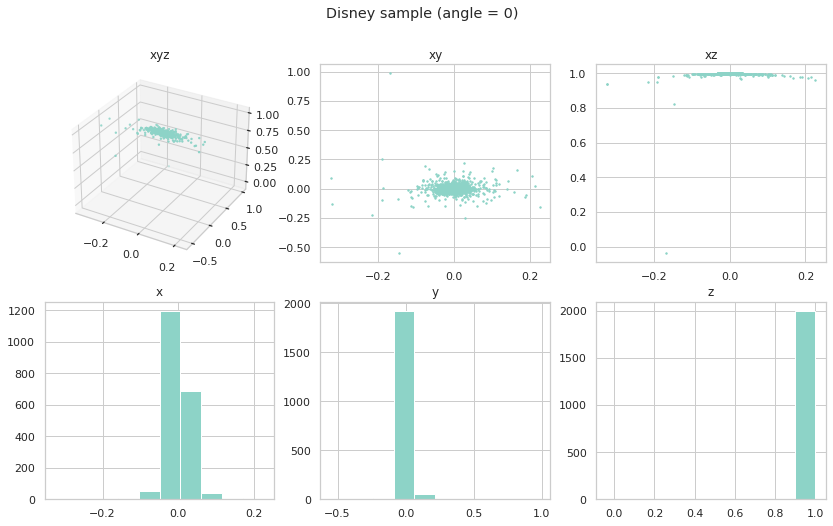

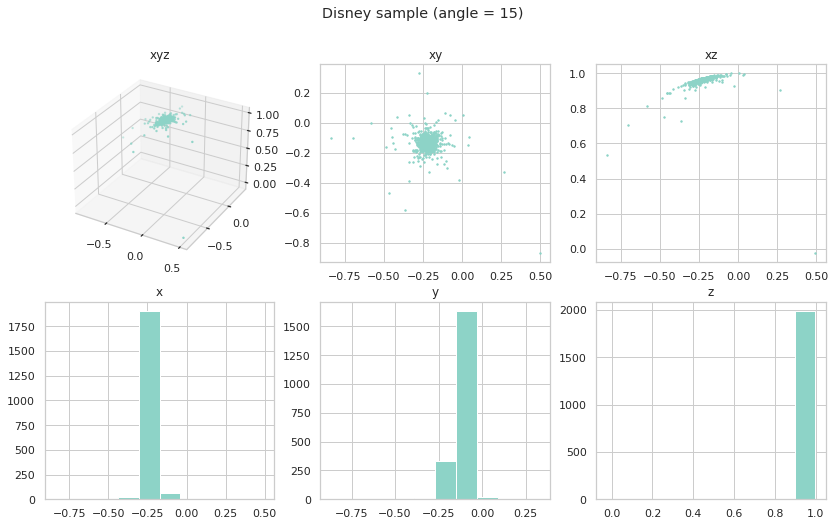

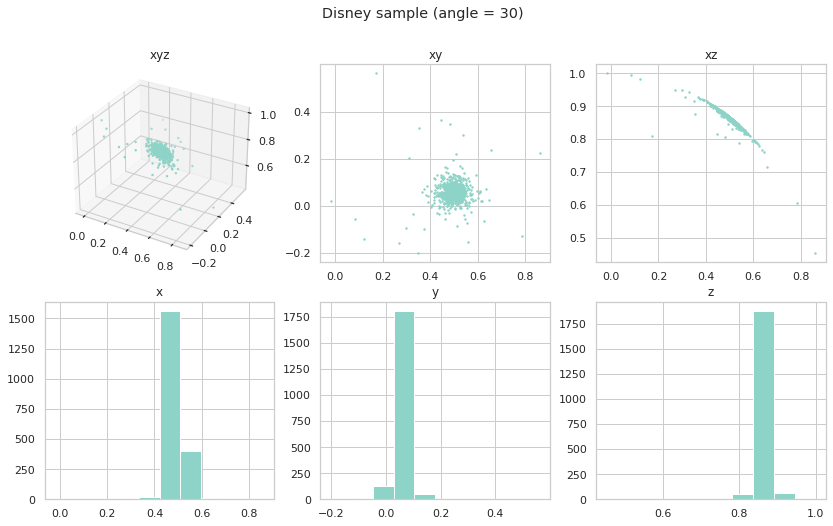

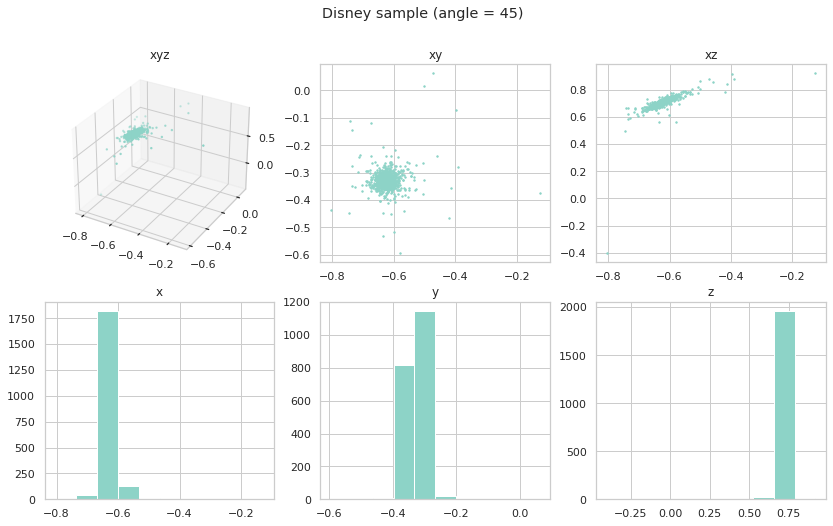

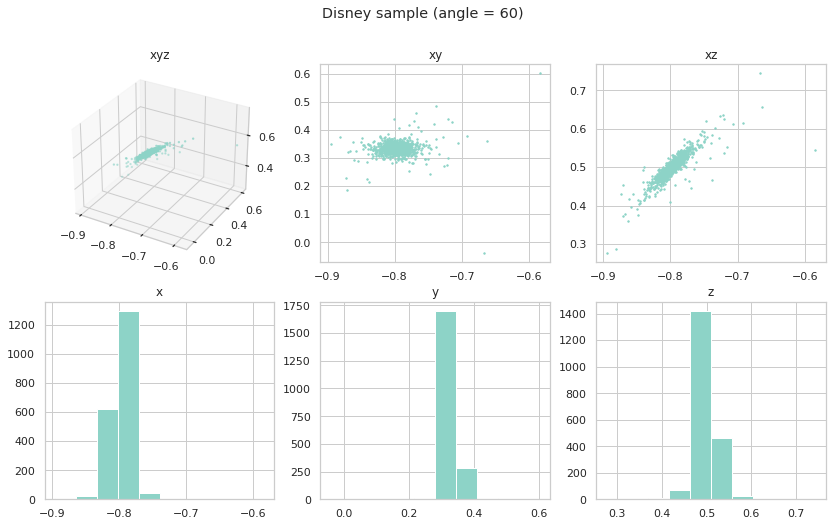

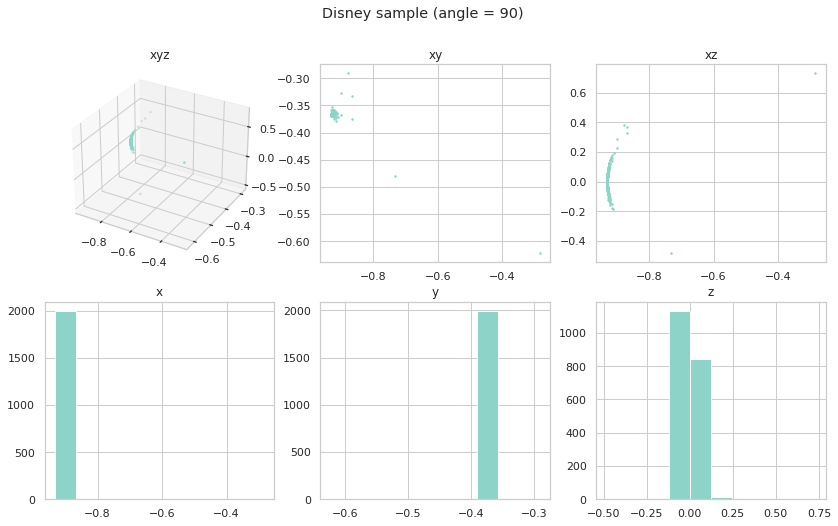

In [240]:
if __name__ == '__main__':
    n = float3(0.0, 0.0, 1.0)
    angles = [0, 15, 30, 45, 60, 90]
    onb = Onb(n)
    for angle in angles:
        phi = 2.0 * pi * random.random()
        x = sin(radians(angle)) * cos(phi)
        y = sin(radians(angle)) * sin(phi)
        z = cos(radians(angle))
        wi = float3(x, y, z)
        wi = onb.inverse_transform(wi)
        wo = disney_sample(n, wi=-wi)
        bsdf_val = disney_brdf(wi, wo, n)
        pdf_val = disney_pdf(wi, wo, n)
        
#         print(bsdf_val.div(pdf_val))
        plot_sampling_func(disney_sample, n, 'Disney sample (angle = {})'.format(angle), num_samples=2000, wi=-wi)
        print('===== angle : {} ====='.format(angle))
        print(wi, wo, n)
        print('bsdf_val = ', bsdf_val)
        print('pdf_val = ', pdf_val)        
        print('bsdf_val / pdf_val = ', bsdf_val.div(pdf_val))        